In [8]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import os
from os.path import join as oj
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.linear_model import LinearRegression, LogisticRegression, RidgeCV
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.decomposition import DictionaryLearning, NMF
from sklearn import metrics
import numpy as np
from collections import Counter
from sklearn.datasets import make_classification
from torch import nn
import torch.nn.functional as F
import torch
from copy import deepcopy
from sklearn import metrics
plt.style.use('dark_background')
import mat4py
import pandas as pd
import data_tracks
from skorch.callbacks import Checkpoint, TrainEndCheckpoint
from skorch import NeuralNetRegressor, NeuralNetClassifier
import models
from imblearn.over_sampling import RandomOverSampler
import pickle as pkl
from style import *


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
df = data_tracks.get_data()
n = df.shape[0]
df.keys()

/accounts/projects/vision/chandan/abc-image-understanding/endocytosis_prediction/data_tracks.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['X_max'] = np.array([max(x) for x in df.X.values])
/accounts/projects/vision/chandan/abc-image-understanding/endocytosis_prediction/data_tracks.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['X_min'] = np.array([max(x) for x in df.X.values])
/accounts/projects/vision/chandan/abc-image-understanding/endocytosis_prediction/data_tracks.py:88: SettingWithCopyWarning: 
A value is trying to 

Index(['X', 'Y', 'X_pval', 'Y_pvals', 'catIdx', 'total_displacement',
       'mean_square_displacement', 'lifetime', 'x_pos', 'y_pos', 'cell_num',
       'len', 'X_max', 'X_min', 'X_mean', 'X_std', 'Y_max', 'Y_mean', 'Y_std',
       'rise', 'fall', 'max_diff', 'min_diff', 'y_score', 'y_thresh',
       'y_single_sig', 'y_double_sig', 'y_consec_sig', 'sc_0', 'sc_1', 'sc_2',
       'sc_3', 'sc_4', 'sc_5', 'sc_6', 'sc_7', 'sc_8', 'sc_9', 'sc_10',
       'sc_11', 'nmf_0', 'nmf_1', 'nmf_2', 'nmf_3', 'nmf_4', 'nmf_5', 'nmf_6',
       'nmf_7', 'nmf_8', 'nmf_9', 'nmf_10', 'nmf_11'],
      dtype='object')

# visualize a single example

In [ ]:
# pick a single interesting example
ex = df[df.lifetime > 250].iloc[0]

plt.figure(dpi=200)
plt.plot(ex['X'], color='red')
plt.xlabel('Time')
plt.ylabel('Clathrin intensity')
plt.show()

plt.figure(dpi=200)
plt.plot(ex['X'], color='red')
plt.xlabel('Time')
plt.ylabel('Clathrin intensity')
plt.show()


plt.plot(ex['x_pos_seq'][:20], ex['y_pos_seq'][:20])
plt.xlabel('x position')
plt.ylabel('y position')
plt.show()

# basic eda

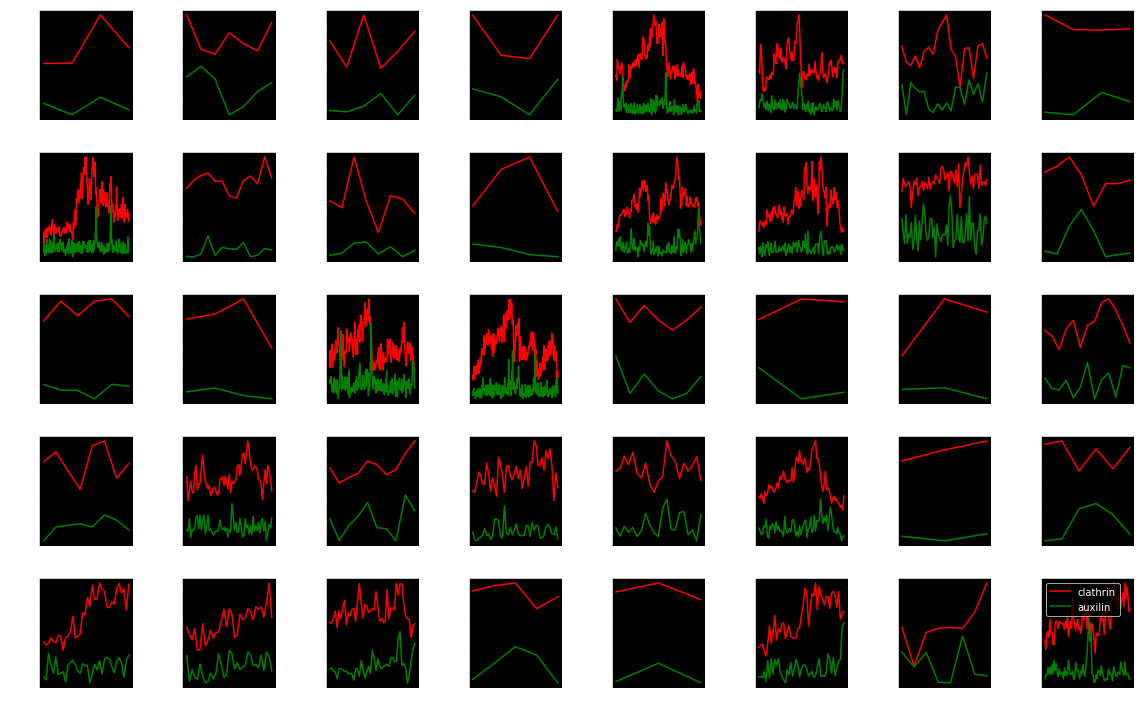

In [3]:
# 0 is the first channel (clathrin)
# R, C = 1, 1
plt.figure(figsize=(16, 10))
R, C = 5, 8
for i in range(R * C):
    plt.subplot(R, C, i + 1)
    row = df.iloc[i]
    plt.plot(row.X, color='red', label='clathrin')
    plt.plot(row.Y, color='green', label='auxilin')
#     plt.axi('off')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
plt.plot(df['x_pos'], df['y_pos'], 'o', alpha=0.1)

# analyze tracking

In [1]:
import mat4py
fname = f'/scratch/users/vision/data/abc_data/auxilin_data_tracked/A7D2/Cell1_1s/TagRFP/Tracking/ProcessedTracks.mat'
mat = mat4py.loadmat(fname)
tracks = mat['tracks']

In [2]:
len(tracks['x'])

1790

In [3]:
i = 2
x = tracks['x'][i][0]
xx = tracks['x'][i][1]

print('clath', len(x), 'aux', len(xx))

clath 300 aux 300


In [ ]:
for i in range(1000):
    print(tracks['t'][i][:5])

# dictionary learning

In [3]:
df_s = df[df.cell_num.isin([1, 2, 3, 4, 5])]
X_mat = data_tracks.extract_X_mat(df_s)
X_mat -= np.min(X_mat)

In [4]:
# sparse coding
def sparse_code():
    n_comps = 12
    alpha = 1
    d = DictionaryLearning(n_components=n_comps, alpha=alpha)
    d.fit(X_mat)
    pkl.dump(d, open(f'dictionaries/sc_{n_comps}_alpha={alpha}.pkl', 'wb'))

In [5]:
def nmf():
    # nmf
    n_comps = 12
    d = NMF(n_components=n_comps)
    d.fit(X_mat)
    pkl.dump(d, open(f'dictionaries/nmf_{n_comps}.pkl', 'wb'))

In [6]:
os.listdir('dictionaries')

['sc_12_alpha=1.pkl', 'nmf_12.pkl', '.ipynb_checkpoints']

In [ ]:
d = pkl.load(open(f'dictionaries/' + 'sc_12_alpha=1.pkl', 'rb'))
# d = pkl.load(open(f'dictionaries/' + 'nmf_12.pkl', 'rb'))
d.transform(X_mat).shape
R, C = 3, 4
i = 0
plt.figure(dpi=200)
vmin = d.components_.min()
vmax = d.components_.max()
# print('err', d.reconstruction_err_ / np.linalg.norm(X_mat, ord='fro'))
for r in range(R):
    for c in range(C):
        plt.subplot(R, C, i + 1)
        plt.plot(d.components_[i], color=cr)
        i += 1
        plt.ylim((vmin, vmax))
        if r < R-1:
            plt.xticks([])
        if c > 0:
            plt.yticks([])
plt.tight_layout()
plt.show()